# 微调模型实现角色扮演对话
本文将演示如何通过模型微调，满足生成小说人物风格对话的功能。

本文数据集来自[CharacterEval: A Chinese Benchmark for Role-Playing Conversational Agent Evaluation](https://github.com/morecry/CharacterEval?tab=readme-ov-file)。处理后的数据集已经上传至千帆平台作为预置数据集，可以直接使用。

本例将基于qianfan==0.3.7展示原始数据处理，加载微调数据集并上传到千帆平台，基于ERNIE-Speed进行fine-tune，多模型比对进行模型评估。

In [95]:
! pip install "qianfan[dataset_base]>=0.3.7" -U
! pip install pandas -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 1.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.16.1 requires dill<0.3.8,>=0.3.0, but you have dill 0.3.8 which is incompatible.
datasets 2.16.1 requires fsspec[http]<=2023.10.0,>=2023.1.0, but you have fsspec 2024.2.0 which is incompatible.
opencompass 0.2.1 requires numpy==1.23.4, but you have numpy 1.26.4 which is incompatible.
opencompass 0.2.1 requires pandas<2.0.0, but you have pandas 2.2.2 which is incompatible.
opencompass 0.2.1 requires tqdm==4.64.1, but you have tqdm 4.66.2 which is incompatible.


In [96]:
import qianfan
print(qianfan.__version__)

0.3.7.1


## 前置准备
- 初始化千帆安全认证AK、SK

In [97]:
import os

# os.environ["QIANFAN_ACCESS_KEY"] = "your_ak"
# os.environ["QIANFAN_SECRET_KEY"] = "your_sk"
os.environ["QIANFAN_QPS_LIMIT"] = "1"
os.environ['QIANFAN_LLM_API_RETRY_COUNT'] = "3"

In [98]:
from qianfan.utils import enable_log
import logging

enable_log(logging.INFO)

## 数据集处理与分析

首先读取一下人物基础信息，并统计角色分布数量

In [99]:
import json
profiles = {}
with open("./data/character_profiles.json", "r") as f: # 加载人物档案
    profiles_json = json.load(f)
    profiles.update({name: str(json_dict) for name, json_dict in profiles_json.items()})
    
role_cnt = {}
role_dialogs = {}
with open("./data/character_dialogs.json", "r") as f:  # 统计对话角色分布，
    dialogs = json.load(f)
    for dialog in dialogs:
        role = dialog['role']
        role_cnt[role] = role_cnt.get(role, 0) + 1
        role_dialogs[role] = role_dialogs.get(role, []) + [dialog['id']]

对统计的数据进行分析

<AxesSubplot:xlabel='role'>

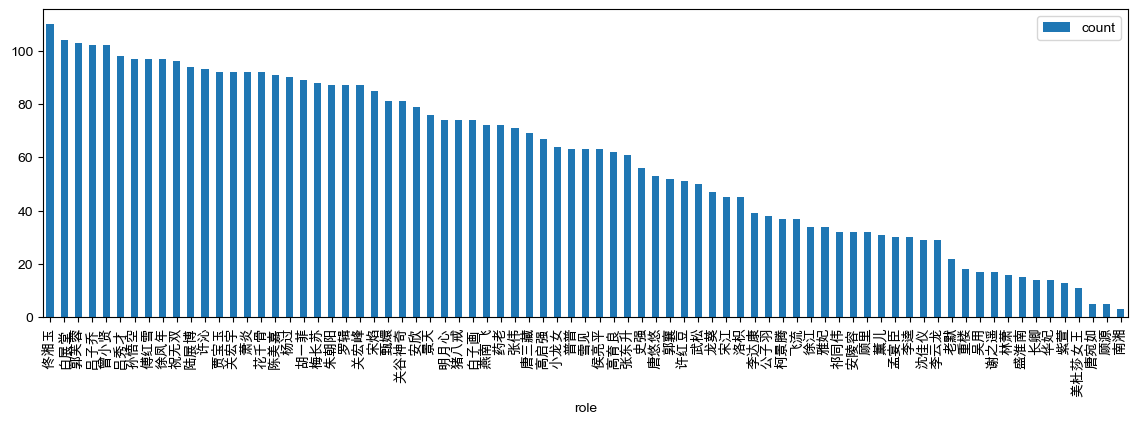

In [100]:
import pandas as pd
import matplotlib as plt
from pprint import pprint

plt.rcParams['font.sans-serif'] = ['SimHei'] # 中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # macOS下中文显示

df = pd.DataFrame.from_dict(role_cnt, orient='index', columns=['count']).reset_index()
df.columns = ['role', 'count']
df.sort_values(by='count', ascending=False, inplace=True)
df.plot(x='role', y='count', kind='bar', figsize=(14, 4))

In [101]:
df.head(5).pivot_table(index='role').T

role,佟湘玉,吕子乔,曾小贤,白展堂,郭芙蓉
count,110.0,102.0,102.0,104.0,103.0


In [102]:
df.tail(5).pivot_table(index='role').T

role,南湘,唐宛如,紫萱,美杜莎女王,顾源
count,3.0,5.0,13.0,11.0,5.0


从统计图中可见，数据集角色分布不均匀，因此需要采用系统抽样方法划分评估集

In [103]:
eval_id_lst = []
sample_dict = {  # 抽取9个角色，每个角色的对话抽取数量如下
    "白展堂":5,
    "朱朝阳" : 5,
    "高启强": 5,
    "龙葵": 5,
    "李云龙": 5,
    "美杜莎女王": 11,
    "顾源": 5,
    "唐宛如": 5,
    "南湘": 3,
}
for role, count in sample_dict.items():
    eval_id_lst.extend(role_dialogs[role][:count])

封装函数将json数据集处理为datasets的格式

In [104]:
def get_prompts(dialog):  # 数据处理具体实现
    global profiles
    role = dialog["role"]
    system_prompt = f"{profiles[role]}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演{role}进行对话。"
    dialog_prompts, dialog_responses = [], []
    dialog_contexts = dialog["context"].split("\n")
    
    for dialog_context in dialog_contexts:
        # 扮演角色设置为response，其他设置为prompt
        if dialog_context.startswith(role):
            dialog_responses.append(dialog_context)
        else:
            dialog_prompts.append(dialog_context)
            
    # 插入系统prompt
    dialog_prompts.insert(0, system_prompt)
    dialog_responses.insert(0, f'好的！现在我来扮演{role}。')
    # 如果第一句是扮演的角色，将其作为系统response的开头，使prompts不少于responses
    if dialog_contexts[0].startswith(role):
        dialog_responses[0] += f'我首先发话{dialog_contexts[0].replace(role, "")}'
        dialog_responses.pop(1)
        
    if len(dialog_prompts) > len(dialog_responses):
        # 有时候对话列表长度是奇数，这里不做操作，zip时会删除多出来的提问
        pass
    
    return [{
        "prompt": prompt,
        "response": [[response]],
        "_group": dialog["id"]}
        for prompt, response in zip(dialog_prompts, dialog_responses)]

In [105]:
sft_train = []
sft_eval = []
with open("./data/character_dialogs.json", "r") as f:
    dialogs = json.load(f)
    for dialog in dialogs:  # 获取对话列表
        if dialog["id"] in eval_id_lst:
            sft_eval.extend(get_prompts(dialog))
        else:
            sft_train.extend(get_prompts(dialog))  # 追加对话列表到py_obj中

In [106]:
from qianfan.dataset import Dataset

train_ds = Dataset.create_from_pyobj(sft_train)
eval_ds = Dataset.create_from_pyobj(sft_eval)
train_ds.pack()
eval_ds.pack()

[INFO] [04-11 10:09:57] utils.py:376 [t:8638464640]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/default_path_6ed005f1-a531-4857-bbbb-ab496d380b55.arrow
[INFO] [04-11 10:09:57] utils.py:388 [t:8638464640]: writing succeeded
[INFO] [04-11 10:09:57] utils.py:262 [t:8638464640]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/default_path_6ed005f1-a531-4857-bbbb-ab496d380b55.arrow
[INFO] [04-11 10:09:57] utils.py:376 [t:8638464640]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/default_path_ab9eb445-98cb-4161-b385-8eaace562a35.arrow
[INFO] [04-11 10:09:57] utils.py:388 [t:8638464640]: writing succeeded
[INFO] [04-11 10:09:57] utils.py:262 [t:8638464640]: start to get memory_map

True

将数据集保存到本地

In [107]:
train_ds.save(data_file="./data/sft_train.jsonl")
eval_ds.save(data_file="./data/sft_eval.jsonl")

[INFO] [04-11 10:09:57] dataset.py:462 [t:8638464640]: no destination data source was provided, construct
[INFO] [04-11 10:09:57] dataset.py:257 [t:8638464640]: construct a file data source from path: ./data/sft_train.jsonl, with args: {}
[INFO] [04-11 10:09:57] file.py:280 [t:8638464640]: use format type FormatType.Jsonl
[INFO] [04-11 10:09:58] dataset.py:462 [t:8638464640]: no destination data source was provided, construct
[INFO] [04-11 10:09:58] dataset.py:257 [t:8638464640]: construct a file data source from path: ./data/sft_eval.jsonl, with args: {}
[INFO] [04-11 10:09:58] file.py:280 [t:8638464640]: use format type FormatType.Jsonl


## 数据集加载

千帆SDK提供了数据集实现帮助我们可以快速的加载本地的数据集到内存，并通过设定DataSource数据源以保存至本地和千帆平台。

In [94]:
from qianfan.dataset import Dataset

# 加载本地数据集
ds: Dataset = Dataset.load(data_file="./data/sft_train.jsonl")
ds.list(5)

[INFO] [04-11 10:09:34] dataset.py:389 [t:8638464640]: no data source was provided, construct
[INFO] [04-11 10:09:34] dataset.py:257 [t:8638464640]: construct a file data source from path: ./data/sft_train.jsonl, with args: {}
[INFO] [04-11 10:09:34] file.py:280 [t:8638464640]: use format type FormatType.Jsonl
[INFO] [04-11 10:09:35] utils.py:262 [t:8638464640]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_train.arrow
[INFO] [04-11 10:09:35] utils.py:237 [t:8638464640]: has got a memory-mapped table
[INFO] [04-11 10:09:35] dataset.py:883 [t:8638464640]: list local dataset data by 5


[{'prompt': "{'姓名': '佟湘玉', '性别': '女', '年龄': '二十七', '绰号': '千手观音', '身份': '同福客栈掌柜，龙门镖局千金', '历史': '出生于陕西汉中的龙门镖局，是镖局老板的独生女。因不满父亲安排的婚事，一怒之下离家出走，来到关中开设了同福客栈。', '特长': '擅长使用暗器，具有迷人的媚眼。', '性格': '自私、贪财、虚荣、好面子，同时也追求享受。', '志向': '希望将同福客栈发展成连锁企业，赚取大量财富，并通过买选票成为武林第一美女。', '人物经历': '佟湘玉是龙门镖局镖头的女儿，原本下嫁衡山派掌门，却在途中成了寡妇。之后，她肩负起照顾小姑子的责任，同时经营同福客栈，努力扶助周围的人。在江湖中，她以智慧和勇气面对各种挑战，追求与白展堂的爱情。', '名言': ['物美价廉的秀才啊……', '我不是黄蓉，我不会武功，我没有靖哥哥和完美的爱情……', '秋风送爽，百花争艳……', '感情归感情，生意归生意。', '美滴很！美滴很！', '生可忍熟不可忍，展堂……', '额姓佟，佟湘玉的玉。', '额跟你拼了！', '关门，放小郭。', '回来！还米有付钱捏！']}\n现在请你扮演一个角色扮演专家。请你根据上述信息扮演佟湘玉进行对话。",
  'response': [['好的！现在我来扮演佟湘玉。我首先发话：（抬头）无双']]},
 {'prompt': '祝无双：嗯。', 'response': [['佟湘玉：你是额滴好姐妹吗。']]},
 {'prompt': '祝无双：嗯，当然是啊，你在我心里，比亲姐姐还要亲呢。',
  'response': [['佟湘玉：那就行了，这封信你拿回去吧。（给她信）']]},
 {'prompt': '祝无双：（拿过来看）什么呀？',
  'response': [['佟湘玉：额滴一些真心话，拿回去慢慢看。（无双表情很异常）咋了这是，无双（把信拿回去）']]},
 {'prompt': '祝无双：没没没，没事，我指是太激动了（夺过信）这是我人生中收到的第一封信。',
  'response': [['佟湘玉：不会吧。']]},
 {'prompt': '祝无双：（吸着鼻子）我从小没有爹没有娘，也没有什么朋友，师兄又太懒，他连张便条都没有写过给我。湘玉姐。',
 

从本地数据集上传到BOS

In [ ]:
# 保存到千帆平台
from qianfan.dataset.data_source import QianfanDataSource
from qianfan.resources.console import consts as console_consts

bos_bucket_name = "your_bucket_name"
bos_bucket_file_path = "/sft_ds/"

In [116]:
# 创建千帆数据集，并上传保存
qianfan_data_source = QianfanDataSource.create_bare_dataset(
    name="random_sft_train",
    template_type=console_consts.DataTemplateType.SortedConversation,
    storage_type=console_consts.DataStorageType.PrivateBos,
    storage_id=bos_bucket_name,
    storage_path=bos_bucket_file_path,
)

ds = ds.save(qianfan_data_source)

[INFO] [04-08 13:21:40] schema.py:36 [t:8640914048]: unpack dataset before validating
[INFO] [04-08 13:21:40] dataset.py:883 [t:8640914048]: list local dataset data by 0
[INFO] [04-08 13:21:40] utils.py:376 [t:8640914048]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_train_db4bc353-132d-4d53-b709-3c1e855601f3.arrow
[INFO] [04-08 13:21:40] utils.py:388 [t:8640914048]: writing succeeded
[INFO] [04-08 13:21:40] utils.py:262 [t:8640914048]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_train_db4bc353-132d-4d53-b709-3c1e855601f3.arrow
[INFO] [04-08 13:21:40] schema.py:39 [t:8640914048]: pack dataset after validation
[INFO] [04-08 13:21:41] utils.py:376 [t:8640914048]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweim

### LLMFinetune 训练
`LLMFinetune` 实现了SFT逻辑的trainer，它内部组装了SFT所需要的基本`Pipeline`, 用于串联数据->训练->模型发布->服务调用等步骤

In [119]:
from qianfan.trainer import LLMFinetune
from qianfan.trainer.configs import TrainConfig
from qianfan.trainer.consts import PeftType

trainer = LLMFinetune(
    train_type="ERNIE-Speed",
    train_config=TrainConfig(
        epoch=3,
        learning_rate=3e-5,
        max_seq_len=4096,
        peft_type=PeftType.ALL,
    ),
    dataset=ds,
)

### 运行任务
同步运行trainer，训练直到模型发布完成

In [120]:
trainer.run()

[INFO] [04-08 13:26:29] persist.py:58 [t:8640914048]: save to /Users/guoweiming/.qianfan_cache/file_tmp/pipeline/OQIc93cMWG
[INFO] [04-08 13:26:34] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:37] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:39] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:42] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:45] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:48] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:51] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:53] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:56] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:26:59] utils.py:682 [t:8640914048]: data releasing, keep polling
[INFO] [04-08 13:27:02] utils.py:689 [t:8640914048]: dat

获取finetune任务输出：

In [131]:
trainer.output

{'datasets': {'sourceType': 'Platform',
  'versions': [{'versionId': 'ds-bp6nj3tmxjmpzuxu'}],
  'splitRatio': 20},
 'task_id': 'task-xv0k9g6tzaj7',
 'job_id': 'job-srm6dvkk4exw',
 'metrics': {'BLEU-4': '15.49%',
  'ROUGE-1': '15.85%',
  'ROUGE-2': '15.44%',
  'ROUGE-L': '15.76%'},
 'model_id': 'am-0tx2sd7e9vh7',
 'model_version_id': 'amv-r7pw72npaipe',
 'model': <qianfan.model.model.Model at 0x7fbebc435a00>}

In [122]:
from qianfan.model import Model

# 从训练结果中获取模型对象
sft_speed: Model = trainer.output["model"]

In [ ]:
#-# cell_skip
from qianfan.model import Service, DeployConfig
from qianfan.model.consts import ServiceType
from qianfan.resources.console.consts import DeployPoolType

# 将模型部署为服务，才能进行多轮对话的批量推理
sft_speed_svc: Service = sft_speed.deploy(DeployConfig(
    name="random_roleplay_svc",
    endpoint_prefix="roleplay",
    replicas=1, # 副本数， 与qps强绑定
    pool_type=DeployPoolType.PrivateResource, # 私有资源池
    service_type=ServiceType.Chat,
))

## 微调结果评估
得到微调模型后，封装本地评估器来评估微调的效果

In [61]:
from qianfan.evaluation.evaluator import LocalEvaluator
from qianfan import ChatCompletion
from qianfan.common.prompt.prompt import Prompt
from qianfan.utils.pydantic import Field

from typing import Optional, Union, Any, Dict, List
import re
import json

class RolePlayLocalJudgeEvaluator(LocalEvaluator):
    model: Optional[ChatCompletion] = Field(default=None, description="model object")
    eval_prompt: Prompt = Field(
        default=Prompt(
            template="""你需要扮演一个裁判的角色，对一段角色扮演的对话内容进行打分，你需要考虑这段文本中的角色沉浸度和对话文本的通畅程度。你可以根据以下规则来进行打分，你可以阐述你对打分标准的理解后再给出分数：
                "4":完全可以扮演提问中的角色进行对话，回答完全符合角色口吻和身份，文本流畅语句通顺
                "3":扮演了提问中正确的角色，回答完全符合角色口吻和身份，但文本不流畅或字数不满足要求
                "2":扮演了提问中正确的角色，但是部分语句不符合角色口吻和身份，文本流畅语句通顺
                "1":能够以角色的口吻和身份进行一部分对话，和角色设定有一定偏差，回答内容不流畅，或不满足文本字数要求
                "0":扮演了错误的角色，没有扮演正确的角色，角色设定和提问设定差异极大，完全不满意
                你的回答需要以json代码格式输出：
                ```json
                {"modelA": {"justification": "此处阐述对打分标准的理解", "score": "此处填写打分结果"}}
                ```

                现在你可以开始回答了：
                问题：{{input}}
                ---
                标准回答：{{expect}}
                ---
                modelA回答：{{output}}
                ---""",
            identifier="{{}}",
        ),
        description="evaluation prompt",
    )

    class Config:
        arbitrary_types_allowed = True

    def evaluate(
        self, input: Union[str, List[Dict[str, Any]]], reference: str, output: str
    ) -> Dict[str, Any]:
        if isinstance(input, str):
            raise ValueError("input should be a list of dict")  # 只处理多轮对话
        score = 0
        try:
            # 渲染评估用的 prompt，传入输入、模型输出和参考答案
            p, _ = self.eval_prompt.render(
                **{
                    "input": "\n".join([i["content"] for i in input]),
                    "output": output,  ## 模型输出，这里为多轮对话时，output 为最后一轮的模型输出
                    "expect": reference,  ## 多轮对话时，reference 为最后一个对话的参考答案
                }
            )
            # 请求模型进行评估
            r = self.model.do(messages=[{"role": "user", "content": p}])
            content = r["result"]
            # 提取出 json 格式的评估结果
            regex = re.compile("\`\`\`json(.*)\`\`\`", re.MULTILINE | re.DOTALL)

            u = regex.findall(content)

            if len(u) == 0:
                score = 0
            else:
                score = float(json.loads(u[0])["modelA"]["score"])
        except Exception as e:
            score = 0
        # 返回评估结果，这里字段需与后续推荐配置时设定的评估字段一致
        return {"score": score}

读取测试集

In [108]:
from qianfan.dataset import Dataset, QianfanDataSource
from qianfan.resources.console import consts as console_consts

test_ds = Dataset.load(data_file="data/sft_eval.jsonl", organize_data_as_group=True, input_columns=["prompt"], reference_column="response")

[INFO] [04-11 10:09:58] dataset.py:389 [t:8638464640]: no data source was provided, construct
[INFO] [04-11 10:09:58] dataset.py:257 [t:8638464640]: construct a file data source from path: data/sft_eval.jsonl, with args: {'input_columns': ['prompt'], 'reference_column': 'response'}
[INFO] [04-11 10:09:58] file.py:280 [t:8638464640]: use format type FormatType.Jsonl
[INFO] [04-11 10:09:58] utils.py:331 [t:8638464640]: need create cached arrow file for /Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_eval.jsonl
[INFO] [04-11 10:09:58] utils.py:376 [t:8638464640]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_eval.arrow
[INFO] [04-11 10:09:58] utils.py:388 [t:8638464640]: writing succeeded
[INFO] [04-11 10:09:58] utils.py:262 [t:8638464640]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/coo

构建千帆自动评估器，这里使用自定义评估和规则评估，具体参见[how_to_use_evaluation](https://github.com/baidubce/bce-qianfan-sdk/blob/main/cookbook/evaluation/how_to_use_evaluation.ipynb)

In [109]:
role_metric: str="""
4:完全可以扮演提问中的角色进行对话，回答完全符合角色口吻和身份，文本流畅语句通顺
3:扮演了提问中正确的角色，回答完全符合角色口吻和身份
2:扮演了提问中正确的角色，但是部分语句不符合角色口吻和身份，文本流畅语句通顺
1:能够以角色的口吻和身份进行一部分对话，和角色设定有一定偏差，回答内容不流畅或不满足文本字数要求
0:扮演了错误的角色，角色设定和提问设定差异极大，完全不满意
"""

In [110]:
from qianfan import ChatCompletion
from qianfan.model import Service

base_speed_svc: Service = Service(model="ERNIE-Speed")  # 预置Speed服务
base_eb4_svc: Service = Service(model="ERNIE-Bot-4")  # 预置EB4服务

local_evaluators = [
    RolePlayLocalJudgeEvaluator(model=ChatCompletion(model="ERNIE-Bot-4")),
]

[WARNING] [04-11 10:10:04] model.py:379 [t:8638464640]: service type should be specified before exec
[WARNING] [04-11 10:10:04] model.py:379 [t:8638464640]: service type should be specified before exec


开始评估，使用预置Speed模型进行对照测试

In [112]:
from qianfan.evaluation import EvaluationManager

em = EvaluationManager(local_evaluators=local_evaluators)

results = []
# results.append(em.eval([sft_speed], test_ds))
results.append(em.eval([base_speed_svc], test_ds))
results.append(em.eval([base_eb4_svc], test_ds))

[INFO] [04-11 10:10:06] evaluation_manager.py:471 [t:8638464640]: start to inference in batch during evaluation
[INFO] [04-11 10:10:06] utils.py:376 [t:13155549184]: start to write arrow table to /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_eval_097b9d83-2dc9-44ad-a2b3-166df300b3f1.arrow
[INFO] [04-11 10:10:06] utils.py:388 [t:13155549184]: writing succeeded
[INFO] [04-11 10:10:06] utils.py:262 [t:13155549184]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/.mapper_cache/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/data/sft_eval_097b9d83-2dc9-44ad-a2b3-166df300b3f1.arrow
[INFO] [04-11 10:10:06] dataset.py:883 [t:13155549184]: list local dataset data by None
[INFO] [04-11 10:10:06] openapi_requestor.py:336 [t:13172338688]: requesting llm api endpoint: /chat/ernie_speed
[INFO] [04-11 10:10:06] openapi_requestor.py:336 [t:13205917696]: requesting llm api endpo

In [116]:
# labels = ["finetune_Speed", "base_Speed", "base_EB4"]
labels = ["base_Speed", "base_EB4"]

os.makedirs("./result", exist_ok=True)
for label, result in zip(labels, results):
    eval_ds = result.result_dataset
    local_path = f'./result/dataset_{label}.jsonl'
    eval_ds.save(data_file=local_path)

[INFO] [04-11 10:16:55] dataset.py:462 [t:8638464640]: no destination data source was provided, construct
[INFO] [04-11 10:16:55] dataset.py:257 [t:8638464640]: construct a file data source from path: ./result/dataset_base_Speed.jsonl, with args: {}
[INFO] [04-11 10:16:55] file.py:280 [t:8638464640]: use format type FormatType.Jsonl
[INFO] [04-11 10:16:55] dataset.py:462 [t:8638464640]: no destination data source was provided, construct
[INFO] [04-11 10:16:55] dataset.py:257 [t:8638464640]: construct a file data source from path: ./result/dataset_base_EB4.jsonl, with args: {}
[INFO] [04-11 10:16:55] file.py:280 [t:8638464640]: use format type FormatType.Jsonl


In [548]:
import pandas as pd

def process_datasets(ds: Dataset):
    # ds_name = ds.list(0)['llm_tag'].split('_')[-1]
    
    ds.col_delete('input_chats')
    ds.col_delete('expected_output')
    ds.col_delete('llm_output')
    ds.col_renames(['llm', 'score'])
    
    # ds.col_renames([ds_name])

    return pd.DataFrame(ds.to_pylist())

def get_GSB(x: pd.Series):
    GSB = {'G': len(x[x>0]), 'S': len(x[x==0]), 'B': len(x[x<0])}
    return ':'.join(map(str,GSB.values()))

In [549]:
dfs = [process_datasets(Dataset.load(data_file=f'./result/dataset_{label}.jsonl')) for label in labels]
# 笛卡尔积
compare_df = pd.concat(dfs, axis=0)
compare_df['llm'] = compare_df['llm'].apply(lambda x:x.split('_')[-1])
group_df = compare_df.groupby('llm').agg({'score':'describe'}).T
group_df

[INFO] [04-11 13:24:04] dataset.py:389 [t:8638464640]: no data source was provided, construct
[INFO] [04-11 13:24:04] dataset.py:257 [t:8638464640]: construct a file data source from path: ./result/dataset_base_Speed.jsonl, with args: {}
[INFO] [04-11 13:24:04] file.py:280 [t:8638464640]: use format type FormatType.Jsonl
[INFO] [04-11 13:24:04] utils.py:262 [t:8638464640]: start to get memory_map from /Users/guoweiming/.qianfan_cache/dataset/Users/guoweiming/PycharmProjects/bce-qianfan-sdk/cookbook/finetune/result/dataset_base_Speed.arrow
[INFO] [04-11 13:24:04] utils.py:237 [t:8638464640]: has got a memory-mapped table
[INFO] [04-11 13:24:04] dataset.py:389 [t:8638464640]: no data source was provided, construct
[INFO] [04-11 13:24:04] dataset.py:257 [t:8638464640]: construct a file data source from path: ./result/dataset_base_EB4.jsonl, with args: {}
[INFO] [04-11 13:24:04] file.py:280 [t:8638464640]: use format type FormatType.Jsonl
[INFO] [04-11 13:24:04] utils.py:262 [t:8638464640]

llm          ERNIE-Bot-4  ERNIE-Speed
score count    49.000000    49.000000
      mean      2.775510     2.102041
      std       1.065859     1.211832
      min       0.000000     0.000000
      25%       2.000000     1.000000
      50%       3.000000     2.000000
      75%       4.000000     3.000000
      max       4.000000     4.000000

array([<AxesSubplot:title={'center':'ERNIE-Bot-4'}>,
       <AxesSubplot:title={'center':'ERNIE-Speed'}>], dtype=object)

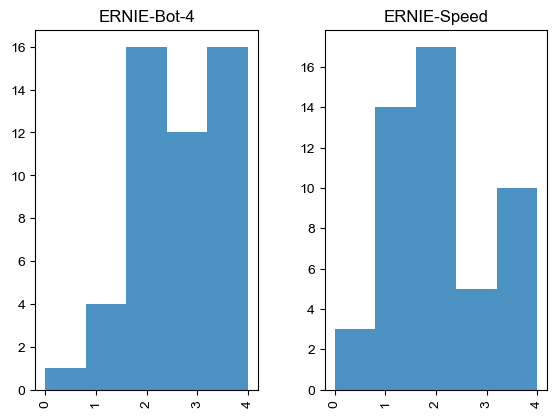

In [551]:
compare_df.hist(by=compare_df['llm'], grid=True, alpha=0.8, bins=5)

In [552]:
compare_df = compare_df.merge(compare_df, left_index=True, right_index=True)

# 计算G:S:B
compare_df['score'] = compare_df['score_x']-compare_df['score_y']
compare_df = compare_df.drop(['score_x','score_y'],axis=1)

# 逆透视处理，获得G:S:B邻接矩阵
compare_df = compare_df.groupby(['llm_x','llm_y']).agg({'score':get_GSB}).rename(columns={'score':'G:S:B'})
compare_df = compare_df.reset_index()
compare_df = compare_df.pivot(index='llm_y',columns='llm_x', values='G:S:B')

In [553]:
compare_df

llm_x,ERNIE-Bot-4,ERNIE-Speed
llm_y,,
ERNIE-Bot-4,0:49:0,8:16:25
ERNIE-Speed,25:16:8,0:49:0


从结果可见，微调后的Speed效果有了很大提升，在准确率、相似度指标上都有优势。